In [340]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import tools
import scipy
import time

def get_fft(x, y):
    '''Return x_fft and y_fft'''
    N = len(y)
    dx = np.mean(np.abs(x[1:] - x[:-1]))
    yf = scipy.fft.fft(y)
    xf = scipy.fft.fftfreq(N, dx)[:N//2]
    # Sort xf
    idx = xf.argsort()
    xf, yf = xf[idx], yf[idx]

    return xf, yf


def get_fft_(x, y, comp=''):
    '''Get specified component of fft in fft-x order'''
    dx = np.abs(np.mean([x[i+1] - x[i] for i in range(len(x)-1)]))
    yf = np.fft.fft(y)
    xf = np.fft.fftfreq(len(y), d=dx)
    idx = np.argsort(xf)
    if comp=='abs':
        yf = np.abs(yf)
    elif comp == 'real':
        yf = yf.real
    elif comp == 'imag':
        yf = yf.imag
    return (xf[idx], yf[idx])

def convolve_with_gaussian(x, y, sigma):
    '''Broaden a curve using gaussian of width sigma, in  units of x
    Make sure x is ordered!'''
    dx = np.mean([np.abs(x[i+1] - x[i]) for i in range(len(x)-2)])
    # print(f"dx: {dx}")
    gx = np.arange(-3 * sigma, 3 * sigma, dx)
    # print("Len gx:",len(gx))
    g = np.exp(-(gx / sigma) ** 2 / 2)
    # plt.plot(gx, gaussian

    n = len(x) + len(gx) - 1
    y_padded = np.pad(y, (0, n - len(y)), mode='constant')
    g_padded = np.pad(g, (0, n - len(g)), mode='constant')
    y_conv = np.fft.ifft(
        np.fft.fft(y_padded) * np.fft.fft(g_padded)
    )
    y_conv = np.real(y_conv)
    y_conv = y_conv[:len(y)]
    # y_conv = np.convolve(y, g, mode="same")
    # y_conv = (y_conv - min(y_conv)) / (max(y_conv) - min(y_conv))
    return y_conv
    # return convolve_1d(y, gaussian)

def convolve_1d(signal, kernel):
    kernel = kernel[::-1]
    return [
        np.dot(
            signal[max(0,i):min(i+len(kernel),len(signal))],
            kernel[max(-i,0):len(signal)-i*(len(signal)-len(kernel)<i)],
        )
        for i in range(1-len(kernel),len(signal))
    ]


def get_gaussian_sample(x, y, x0, sigma, crop_sigma=None):
    '''Return element-wise multiplication of your sample data with a gaussian of width sigma centered at x0'''
    if crop_sigma:
        idx = np.where(np.abs(x - x0) <= crop_sigma * sigma)
        gaussian_x = x[idx]
        gaussian_y = y[idx]
    else:
        idx = np.where(np.abs(x) >= 0)
        gaussian_x = x.copy()
        gaussian_y = y.copy()
    gaussian = np.exp(-((gaussian_x - x0)/sigma) ** 2 / 2)
    return idx, np.multiply(gaussian_y, gaussian)



class musicTranscriber():
    """
    Class to input .wav piano audio data and transcribe a pdf of sheet music
    """
    def __init__(self, input_wav_filename, display=False):
        # self.verbose = verbose
        self.display = display
        if self.display:
            # Get a colormap for 88 keys
            self.cmap = plt.get_cmap('gnuplot')
            self.colors = [self.cmap(i) for i in np.linspace(0, 1, 88)]
            self.sm = plt.cm.ScalarMappable(cmap=self.cmap, norm=plt.Normalize(vmin=0, vmax=87))
            self.sm.set_array([])  # Needed for creating the colorbar

        self.input_wav_filename = input_wav_filename
        self.key_tones = [440.0 * (2 ** (i / 12.)) for i in range(-48, 40)]

    def load_data(self):
        '''Load wav data into np arrays'''
        sample_input = scipy.io.wavfile.read(self.input_wav_filename)
        sample_rate = sample_input[0]
        sample_data_channels = sample_input[1]
        sample_data = sample_data_channels[:, 0] # Only single-channel data supported
        sample_time = np.arange(len(sample_data)) / sample_rate
        self.sample_rate = sample_rate
        self.data_amps = sample_data
        self.data_times = sample_time
        return sample_data, sample_time, sample_rate

    def crop(self, sample_start_time=None, sample_end_time=None, display=None):
        '''Crop audio data'''
        data_amps = self.data_amps
        data_times = self.data_times
        if display is None:
            display = self.display

        if sample_start_time is None:
            sample_start_time = 0
        if sample_end_time is None:
            sample_end_time = data_times[-1]

        idx = np.where((data_times >= sample_start_time) & (data_times < sample_end_time))
        # sample_time, data_amps = sample_time[idx], data_amps[idx]
        # cropped_sample_time -= cropped_sample_time[0]
            
        if display:
            fig, axs = plt.subplots(2)
            ax = axs[0]
            ax.plot(data_times, data_amps, color="gray", label="input wav file data")
            ax.vlines([sample_start_time, sample_end_time], [np.min(data_amps)] * 2, [np.max(data_amps)] * 2, label="crop window")
            ax.set_xlabel('s')
            ax.legend()
            ax = axs[1]
            ax.plot(data_times[idx], data_amps[idx], 'r', label="cropped input data")
            ax.set_xlabel('s')
            plt.legend()
            plt.show()

        self.data_amps = data_amps[idx]
        self.data_times = data_times[idx]
        self.sample_start_time = sample_start_time
        self.sample_end_time = sample_end_time
        return self.data_amps, self.data_times

    def get_characteristic_chord_duration(self, display=None):
        if display is None:
            display = self.display
        '''Take spectrum of the sample data and get strongest frequency between 1-10 Hz'''
        y, x = self.data_amps, self.data_times
        xf, yf = get_fft(x, y)
        idx = np.where((xf >= 0) & (xf < 20))
        xf, yf = xf[idx], yf[idx]
        # Process the data a bit to make the peak-finding easier
        conv_width = 0.05 # Convolve width in Hz
        yf_ = convolve_with_gaussian(xf, np.abs(yf)**2, conv_width)
        chord_freq_idx = np.argmax(yf_)
        chord_frequency = xf[chord_freq_idx]
        if display:
            fig, axs = plt.subplots(3, figsize=(5,8))
            ax = axs[0]
            ax.plot(x, y, 'b', label='audio data')
            ax.set_xlabel('s')
            ax.legend()
            ax = axs[1]
            ax.plot(xf, np.abs(yf), 'r', label='abs spectrum (low freqs)')
            ax.set_xlabel('Hz')
            ax.legend()
            ax = axs[2]
            ax.plot(xf, yf_, 'r', label=f'abs squared and conv width {conv_width}Hz')
            ax.plot(xf[chord_freq_idx], yf_[chord_freq_idx], 'g', marker='v', label='char. chord')
            ax.legend()
            ax.set_xlabel('Hz')
            plt.suptitle('Characteristic chord in low-frequency spectrum')
            plt.tight_layout()
            plt.show()
            print(f"Characteristic chord frequency is {round(chord_frequency, 3)} Hz (chord length {round(1/chord_frequency, 3)} s)")
        self.chord_frequency = chord_frequency
        self.chord_length = 1 / chord_frequency



    def get_chord_boundary_times(self, display=None, conv_width=0.05):
        """Find chord start times"""
        if display is None:
            display = self.display
        y = self.data_amps
        y = y / np.max(np.abs(y))
        x = self.data_times
        y_ = convolve_with_gaussian(x, np.abs(y)**2, conv_width)
        y_ = y_ / np.max(y_)
        dy = np.gradient(y_)
        dy = dy / np.max(np.abs(dy))
        if display:
            fig, axs = plt.subplots(2)
            ax = axs[0]
            ax.plot(x, y, 'r', label='sample')
            ax.set_xlabel('s')
            ax.legend()
            ax = axs[1]
            ax.plot(x, y_, 'r', alpha=0.5, label=f'processed width {conv_width}s)')
            ax.plot(x, dy, 'b', alpha=0.5, linewidth=0.5, label=f'gradient')
            ax.hlines(0, min(x), max(x), 'k', linewidth=0.5)
            ax.legend(fontsize=6)
            plt.show()
    
    def play_sample(self, display=None, playback_speed=1.0, gif_delay=0.5):
        import sounddevice as sd
        import os
        import shutil
        import IPython

        if display is None:
            display = self.display
        
        # Define function to play audio
        def play_audio():
            sd.play(self.data_amps, self.sample_rate)
            sd.wait()

        def display_gif():
            IPython.display.display(IPython.display.HTML(f'<img src="sample.gif" />'))

        if display:
            x, y = self.data_times, self.data_amps
            tmp_folder = 'tmp/gif'
            if os.path.exists(tmp_folder):
                shutil.rmtree(tmp_folder)
            os.mkdir(tmp_folder)

            gif_time_step = 0.1
            gif_times = np.arange(self.sample_start_time, self.sample_end_time, gif_time_step)
            for gif_idx, gif_time in enumerate(gif_times):
                fig, ax = plt.subplots()
                ax.plot(x, y, 'b', label='Sample audio data')
                ax.plot([gif_time] * 2, [min(y), max(y)], 'k')
                ax.set_xlabel('s')
                ax.set_title(f't = {gif_time}s')
                gif_file_idx = "0" * (5 - len(str(gif_idx))) + str(gif_idx)
                plt.savefig(f"{tmp_folder}/{gif_file_idx}.png")
                plt.close()
            print(f"Saved gif figs")
            
            images_lst = [f'{tmp_folder}\\{x}' for x in os.listdir(tmp_folder)]
            tools.save_gif_from_images(
                images_lst,
                frame_duration_ms= gif_time_step / playback_speed,
                save_filename='sample.gif'
            )

        sd.play(self.data_amps, self.sample_rate * playback_speed)
        sd.wait()

        # # Create threads for concurrent execution
        # audio_thread = threading.Thread(target=play_audio)
        # gif_thread = threading.Thread(target=display_gif)

        # # Start both threads
        # audio_thread.start()
        # time.sleep(gif_delay)
        # gif_thread.start()

        # # Wait for both threads to finish
        # audio_thread.join()
        # gif_thread.join()

def add_note(time_array, amps_array, note_idx, note_time):
    """Get time series of amplitudes and add a note (note_idx [0, 87]) played at note_time"""

    return

def get_note_profile(time_data, amps_data):
    """Analyze time series of amplitudes and get the profile of the wave packet representing note(s) being played"""
    return

def simulate_note(time_array, note_idx, note_time):
    """Get the time series amplitudes of a note being played"""
    sample_rate = 3
    time_array = np.arange(0, 2, 1/sample_rate)
    return



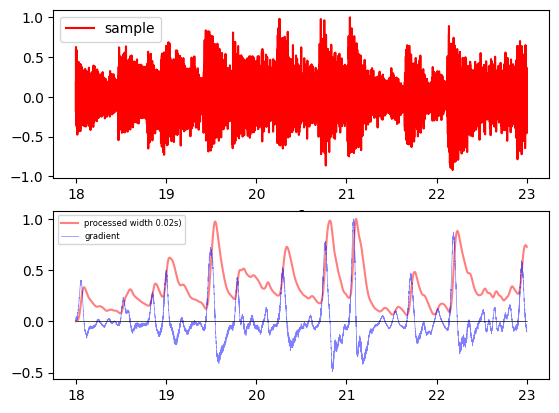

In [341]:
mt = musicTranscriber("Super Mario Bros. Theme  but its in a minor key.wav")

y, x, hz = mt.load_data()
mt.get_characteristic_chord_duration(display=False)

mt.crop(sample_start_time=18, sample_end_time=23)
mt.get_chord_boundary_times(display=True, conv_width=0.02)
time.sleep(2)
mt.play_sample(display=False, playback_speed=.5)


In [336]:
scipy.io.wavfile.write("sample.wav", mt.sample_rate, mt.data_amps.astype(np.int16))

In [337]:
from PIL import Image
import cv2
import numpy as np
from moviepy.editor import AudioFileClip, VideoFileClip
import os

# Paths to input files
gif_path = 'sample.gif'
audio_path = 'sample.wav'
output_video_path = 'sample.mp4'

# Step 1: Extract frames from the GIF
gif = Image.open(gif_path)
frames = []

while True:
    # Convert the current frame to a numpy array (for OpenCV)
    frame = np.array(gif.convert("RGB"))
    frames.append(frame)
    
    try:
        # Move to the next frame in the GIF
        gif.seek(gif.tell() + 1)
    except EOFError:
        break

# Step 2: Create a video from the GIF frames using OpenCV
frame_height, frame_width, _ = frames[0].shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Video codec
video_writer = cv2.VideoWriter('temp_video.mp4', fourcc, 10, (frame_width, frame_height))  # 10 FPS

# Write each frame to the video file
for frame in frames:
    video_writer.write(frame)

video_writer.release()  # Close the video writer

# Step 3: Add audio to the video using moviepy
video_clip = VideoFileClip('temp_video.mp4')
audio_clip = AudioFileClip(audio_path)

# Set the audio of the video clip to be the audio file
video_clip = video_clip.set_audio(audio_clip)

# Step 4: Write the final video to an output file
video_clip.write_videofile(output_video_path, codec='libx264')

# Clean up the temporary video file
os.remove('temp_video.mp4')

print(f"Video created and saved as {output_video_path}")

Moviepy - Building video sample.mp4.
MoviePy - Writing audio in sampleTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video sample.mp4



TypeError: must be real number, not NoneType

In [ ]:
    # def get_chord_boundary_times_(self, display=None):
    #     '''Find moving minima across audio data and use characteristic chord data to find boundaries between chords'''
    #     y = self.data_amps
    #     x = self.data_times
    #     y = y / np.max(y)
    #     if display is None:
    #         display = self.display

    #     y_ = convolve_with_gaussian(x, np.abs(y)**2, .01)

    #     # Get moving minimum
    #     window = 0.5
    #     # print(int(window * self.sample_rate))
    #     # print(len(x))
    #     window_len = int(window * self.sample_rate)
    #     moving_minima = np.zeros((len(x) - window_len))
    #     moving_minima_idx = []
    #     moving_minima_times = []
    #     for x0 in np.arange(self.sample_start_time, self.sample_end_time, 0.3):
    #         idx = np.where((x >= x0) & (x < x0 + 0.3))
    #         # print("idx:",idx)
    #         local_y = y_[idx]
    #         local_x = x[idx]
    #         local_min_val = np.min(local_y)
    #         # print("idx:",idx[0][0])
    #         local_min_idx = np.argmin(local_y) + idx[0][0]
    #         # plt.plot([x[local_min_idx]] * 2, [-1, 1], 'k', linewidth=0.5)
    #         moving_minima_idx.append(local_min_idx)
    #         moving_minima_times.append(x[local_min_idx])

    #     print("set of minimum idx:",list(set(moving_minima_idx)))

    #     # Check for pairs of local minima that are too close
    #     nearest_neighbor_idx = 0
    #     nearest_neighbors = []
    #     for min_idx, min_time in enumerate(moving_minima_times):
    #         diffs = np.abs(moving_minima_times - min_time)
    #         non0_min = np.min(diffs[np.where(diffs>0)])
    #         idx = int(np.where((diffs == non0_min))[0][0])
    #         print(f"dist:",moving_minima_times[idx] - min_time)
    #         dist = np.abs(moving_minima_times[idx] - min_time)
    #         if dist < 0.5 * self.chord_length:
    #             nearest_neighbors.append((int(moving_minima_idx[min_idx]), int(moving_minima_idx[idx])))
    #     print("nn pairs:",nearest_neighbors)

    #     nn_pairs = []
    #     for nn_pair in nearest_neighbors:
    #         rev_pair = (nn_pair[1], nn_pair[0])
    #         if rev_pair in nearest_neighbors:
    #             print("found matching pair:", nn_pair, rev_pair)
    #             nn_pairs.append(nn_pair)
    #             nearest_neighbors.remove(rev_pair)
    #     print("nearest_neighbors:",nn_pairs)

    #     print(f"before removing nns")
    #     # For too-close pairs, only keep the one with lower minimum value
    #     for nn_pair in nn_pairs:
    #         min_vals = y_[nn_pair[0]], y_[nn_pair[1]]
    #         print("nn_pair",nn_pair)
    #         print("min vals:",min_vals)
    #         # retain only the lower of the two
    #         remove_idx = nn_pair[np.argmax(min_vals)]
    #         moving_minima_idx.remove(remove_idx)
    #     print("moving minima idx with doubles removed:",moving_minima_idx)

    #     if display:
    #         fig, ax = plt.subplots(figsize=(9,3))
    #         ax.plot(x,y, label='data')
    #         ax.plot(x, y_, 'r', label='abs-convoluted')
    #         ax.plot(x, -y_, 'r', label='neg abs-convoluted')
    #         ax.plot([x[moving_minima_idx[0]]] * 2, [-1, 1], 'k', linewidth=0.5, label='chord boundary')
    #         for min_idx in moving_minima_idx[1:]:
    #             ax.plot([x[min_idx]] * 2, [-1, 1], 'k', linewidth=0.5)
    #         ax.legend()
    #         plt.show()


    #     chord_boundary_times = x[moving_minima_idx]
    #     print("chord boundary times: ",chord_boundary_times)

In [ ]:


    # def find_chord_boundaries(self):
    #     y = np.abs(self.data_amps)
    #     x = self.data_times
    #     sigma = 0.03
    #     y_ = convolve_with_gaussian(x, y, sigma) # Smooth out the individual pitch frequencies
    #     if self.display:
    #         fig, ax = plt.subplots()
    #         ax.plot(x, y, 'k', label="Before convolution")
    #         ax.plot(x, y_, 'r', label=f"After convolution {sigma}s")
    #         ax.legend()
    #         plt.show()

        # '''Sample sample_width-long portions of audio data every sample_step seconds and get pitch amplitude for all 88-key pitches
        # Take the spectrum of that and find highest sub-1s beat 
        # '''
        # y = self.data_amps
        # x = self.data_times
        # sample_step = 0.01
        # sample_width = 0.02
        # pitch_times = np.arange(x[0], x[-1], sample_step)
        # pitch_amps = np.zeros((len(self.key_tones), len(pitch_times)))
        # for sample_i, sample_time in enumerate(pitch_times):
        #     idx, y_ = get_gaussian_sample(x, y, sample_time, sample_width)
        #     sample_fft_x, sample_fft_y = get_fft(x[idx], y_[idx])
        #     for key_i, key_freq in enumerate(self.key_tones):
        #         pitch_amps[key_i, sample_i] = np.interp(key_freq, sample_fft_x, np.abs(sample_fft_y))
        # int_pitch_amps = np.sum(pitch_amps, axis=0)
        
        # xf, yf = get_fft(pitch_times[:], int_pitch_amps[:])
        # beats = 1/xf
        # xf_idx = np.where((beats > 0) & (beats < 0.5))

        # xf = xf[xf_idx]
        # yf = np.abs(yf)[xf_idx]
        # beats = beats[xf_idx]
        # # beats = 1/dt

        # max_beat_idx = np.where(yf == np.max(yf))[0][0]
        # rough_beat = 1 / xf[max_beat_idx]
        
        # if self.display:
        #     fig, axs = plt.subplots(2)
        #     ax = axs[0]
        #     for key_i in range(pitch_amps.shape[0]):
        #         ax.plot(pitch_times, pitch_amps[key_i, :], color=self.colors[key_i])
        #     ax.set_xlabel('time')
        #     ax.set_ylabel('pitch amp')
        #     ax.set_title(f'Sample step, width: {sample_step}, {sample_width}')
        #     plt.colorbar(self.sm, ax=ax)

        #     ax = axs[0]
        #     ax.plot(pitch_times, int_pitch_amps, 'k', label='integrated pitches')
        #     plt.title(f"Spectral amplitude versus sampled time")
        #     plt.xlabel(f"Sampled time")
        #     plt.ylabel(f"Spectral amplitude")
        #     plt.legend()
            
        #     ax = axs[1]
        #     ax.plot(xf, yf, 'r')
        #     ax.plot(xf[max_beat_idx], yf[max_beat_idx], 'ro')
        #     plt.xlabel('1/s')
        #     plt.ylabel('amp')
        #     plt.show()
        #     print(f"The rough beat is {rough_beat} seconds")
        # self.pitch_times = pitch_times
        # self.pitch_amps = pitch_amps
        # return rough_beat
        
    # def get_average_chord_duration(self, display=None):
    #     """
    #     Get the rough sub-1s beat for a beat_sample_width-long portion of audio every beat_sample_step seconds
    #     The average chord duration is the average of the rough beats
    #     """
    #     if display is None:
    #         display = self.display
    #     beats = []
    #     beat_sample_width = 1.5
    #     beat_sample_start = self.sample_time[0] 
    #     beat_sample_end = self.sample_time[-1] - beat_sample_width
    #     beat_sample_step = 2
    #     for sample_start_time, sample_end_time in zip(
    #         list(np.arange(beat_sample_start, beat_sample_end - beat_sample_width, beat_sample_step)),
    #         list(np.arange(beat_sample_start + beat_sample_width, beat_sample_end, beat_sample_step))
    #     ):
    #         self.preprocess(sample_start_time=sample_start_time, sample_end_time=sample_end_time)
    #         beats.append(self.get_rough_beat())
    #     rough_beat = np.mean(beats)
    #     print(f"The rough average chord duration is {rough_beat}s")
    #     self.average_chord_duration = rough_beat
    #     return rough_beat
    

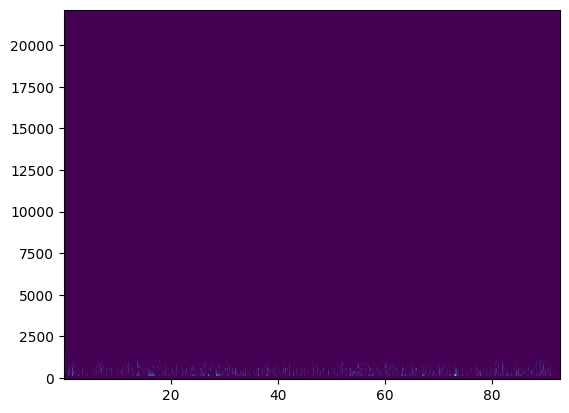

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram

# Load audio file (replace with your file path)
fs, audio_data = wavfile.read('Super Mario Bros. Theme  but its in a minor key.wav')

# If stereo, convert to mono by averaging the channels
if len(audio_data.shape) > 1:
    audio_data = audio_data.mean(axis=1)

# Generate a spectrogram using scipy
f, t, Sxx = spectrogram(audio_data, fs)
Sxx_to_Pxx_dB = 10*np.log10(Sxx/Pxx)

plt.pcolormesh(t, f, Sxx)
plt.show()
# # Replace zeros with a small positive value to avoid log(0)
# Sxx = np.maximum(Sxx, 1e-10)  # Ensure there are no zeros

# # Convert frequency axis to logarithmic scale for plotting
# log_frequencies = np.log10(f)

# # Plot the spectrogram
# plt.figure(figsize=(10, 6))

# # Show the spectrogram with the log-scaled frequency axis
# plt.pcolormesh(t, log_frequencies, 10 * np.log10(Sxx), shading='auto')

# # Set labels and title
# plt.ylabel('Frequency (log scale)')
# plt.xlabel('Time (s)')
# plt.title('Log-Scaled Spectrogram')

# # Customize the y-axis to show piano note frequencies
# piano_notes = ['A0', 'A#0', 'B0', 'C1', 'C#1', 'D1', 'D#1', 'E1', 'F1', 'F#1', 'G1', 'G#1', 'A1', 'A#1', 'B1', 
#                'C2', 'C#2', 'D2', 'D#2', 'E2', 'F2', 'F#2', 'G2', 'G#2', 'A2', 'A#2', 'B2', 'C3', 'C#3', 'D3', 
#                'D#3', 'E3', 'F3', 'F#3', 'G3', 'G#3', 'A3', 'A#3', 'B3', 'C4', 'C#4', 'D4', 'D#4', 'E4', 'F4', 
#                'F#4', 'G4', 'G#4', 'A4', 'A#4', 'B4', 'C5', 'C#5', 'D5', 'D#5', 'E5', 'F5', 'F#5', 'G5', 'G#5', 
#                'A5', 'A#5', 'B5', 'C6', 'C#6', 'D6', 'D#6', 'E6', 'F6', 'F#6', 'G6', 'G#6', 'A6', 'A#6', 'B6', 
#                'C7', 'C#7', 'D7', 'D#7', 'E7', 'F7', 'F#7', 'G7', 'G#7', 'A7', 'A#7', 'B7', 'C8']
# # Corresponding frequencies of the piano notes (A0 to C8)
# piano_frequencies = [27.5, 29.1352, 30.8677, 32.7032, 34.6478, 36.7081, 38.8909, 41.2034, 43.6535, 46.2493, 
#                      49.0000, 51.9130, 55.0000, 58.2705, 61.7354, 65.4064, 69.2957, 73.4162, 77.7817, 82.4069, 
#                      87.3071, 92.4986, 97.9989, 103.826, 110.000, 116.541, 123.471, 130.813, 138.591, 146.832, 
#                      155.563, 164.814, 174.614, 184.997, 195.998, 207.652, 220.000, 233.082, 246.942, 261.626, 
#                      277.183, 293.665, 311.127, 329.628, 349.228, 369.994, 391.995, 415.305, 440.000, 466.164, 
#                      493.883, 523.251, 554.365, 587.330, 622.254, 659.255, 698.456, 739.989, 783.991, 830.609, 
#                      880.000, 932.328, 987.767, 1046.502, 1108.730, 1174.659, 1244.508, 1318.510, 1396.913, 
#                      1479.978, 1567.982, 1661.219, 1760.000, 1864.656, 1975.533, 2093.004, 2217.461, 2349.318, 
#                      2489.016, 2637.020, 2793.826, 2959.955, 3135.963, 3322.438, 3520.000]

# # Set the y-ticks and labels to show piano notes
# y_ticks = np.log10(piano_frequencies)
# plt.yticks(y_ticks, piano_notes)

# # Show the plot
# plt.colorbar(label='Power (dB)')
# plt.show()


In [ ]:

# y = y / np.max(y)
# plt.plot(x,y)

# y_ = convolve_with_gaussian(x, np.abs(y), .01)
# plt.plot(x, y_, 'r')
# plt.plot(x, -y_, 'r')

# window = 0.5
# print(int(window * hz))
# print(len(x))
# window_len = int(window * hz)
# moving_minima = np.zeros((len(x) - window_len))
# moving_minima_idx = []
# moving_minima_times = []
# for x0 in np.arange(sample_start_time, sample_end_time, 0.3):
#     idx = np.where((x >= x0) & (x < x0 + 0.3))
#     # print("idx:",idx)
#     local_y = y_[idx]
#     local_x = x[idx]
#     local_min_val = np.min(local_y)
#     # print("idx:",idx[0][0])
#     local_min_idx = np.argmin(local_y) + idx[0][0]
#     # plt.plot([x[local_min_idx]] * 2, [-1, 1], 'k', linewidth=0.5)
#     moving_minima_idx.append(local_min_idx)
#     moving_minima_times.append(x[local_min_idx])

# print("set of minimum idx:",list(set(moving_minima_idx)))
# # plt.show()

# # Check for pairs of local minima that are too close
# nearest_neighbor_idx = 0
# nearest_neighbors = []
# for min_idx, min_time in enumerate(moving_minima_times):
#     diffs = np.abs(moving_minima_times - min_time)
#     non0_min = np.min(diffs[np.where(diffs>0)])
#     idx = int(np.where((diffs == non0_min))[0][0])
#     print(f"dist:",moving_minima_times[idx] - min_time)
#     dist = np.abs(moving_minima_times[idx] - min_time)
#     if dist < 0.5 * average_chord_duration:
#         nearest_neighbors.append((int(moving_minima_idx[min_idx]), int(moving_minima_idx[idx])))
# print("nn pairs:",nearest_neighbors)

# nn_pairs = []
# for nn_pair in nearest_neighbors:
#     rev_pair = (nn_pair[1], nn_pair[0])
#     if rev_pair in nearest_neighbors:
#         print("found matching pair:", nn_pair, rev_pair)
#         nn_pairs.append(nn_pair)
#         nearest_neighbors.remove(rev_pair)
# print("nearest_neighbors:",nn_pairs)

# print(f"before removing nns")
# # For too-close pairs, only keep the one with lower minimum value
# for nn_pair in nn_pairs:
#     min_vals = y_[nn_pair[0]], y_[nn_pair[1]]
#     print("nn_pair",nn_pair)
#     print("min vals:",min_vals)
#     # retain only the lower of the two
#     remove_idx = nn_pair[np.argmax(min_vals)]
#     moving_minima_idx.remove(remove_idx)
# print("moving minima idx with doubles removed:",moving_minima_idx)

# for min_idx in moving_minima_idx:
#     plt.plot([x[min_idx]] * 2, [-1, 1], 'k', linewidth=0.5)
# plt.show()

# chord_boundary_times = x[moving_minima_idx]
# print("chord boundary times: ",chord_boundary_times)

C:\Users\erica\AppData\Local\Temp\ipykernel_19024\1340137924.py:216: RuntimeWarning: divide by zero encountered in divide
  beats = 1/xf


The rough beat is 0.3750000000000004 seconds
The rough beat is 0.4999999999999982 seconds
The rough beat is 0.37500000000000533 seconds
The rough beat is 0.37500000000000533 seconds
The rough beat is 0.25000000000000355 seconds
The rough beat is 0.25000000000000355 seconds
The rough beat is 0.37500000000000533 seconds
The rough beat is 0.25000000000000355 seconds
The rough beat is 0.29999999999998295 seconds
The rough beat is 0.4999999999999716 seconds
The rough beat is 0.29999999999998295 seconds
The rough beat is 0.4999999999999716 seconds
The rough beat is 0.3749999999999787 seconds
The rough beat is 0.4999999999999716 seconds
The rough beat is 0.3749999999999787 seconds
The rough beat is 0.29999999999998295 seconds
The rough beat is 0.2499999999999858 seconds
The rough beat is 0.3749999999999787 seconds
The rough beat is 0.3749999999999787 seconds
The rough beat is 0.3749999999999787 seconds
The rough beat is 0.3749999999999787 seconds
The rough beat is 0.4999999999999716 seconds
T

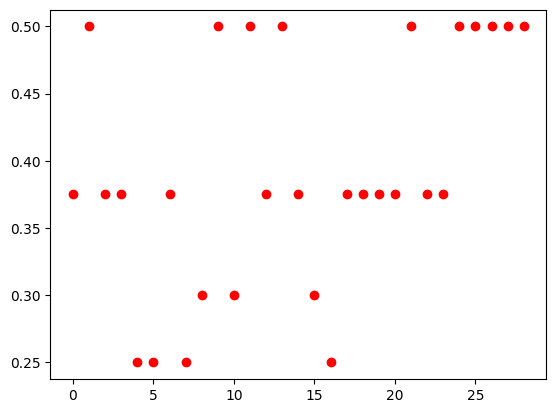

In [ ]:
mt = musicTranscriber(
    "Super Mario Bros. Theme  but its in a minor key.wav", 
    display=False
)
y, x, hz = mt.load_data()
beats = []
beat_sample_width = 1.5
beat_sample_start = 0.5
beat_sample_end = 60
beat_sample_step = 2
for sample_start_time, sample_end_time in zip(
    list(np.arange(beat_sample_start, beat_sample_end - beat_sample_width, beat_sample_step)),
    list(np.arange(beat_sample_start + beat_sample_width, beat_sample_end, beat_sample_step))
):
    y, x = mt.preprocess(sample_start_time=sample_start_time, sample_end_time=sample_end_time)
    beats.append(mt.get_rough_beat())
fig, axs = plt.subplots()
axs.plot(beats, 'ro')
rough_beat = np.mean(beats)

c:\Users\erica\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\erica\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


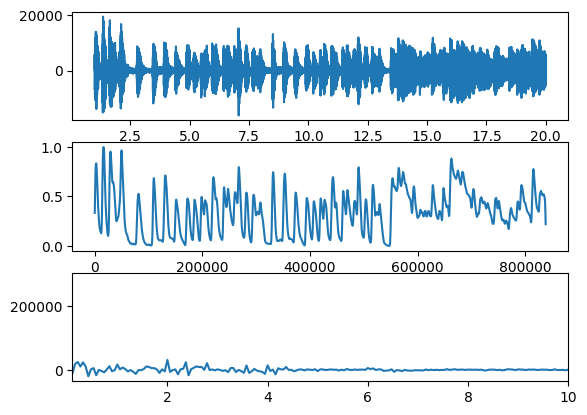

In [3]:
fig,axs=plt.subplots(3)
axs[0].plot(x,y)
from scipy.ndimage import gaussian_filter1d
y_ = convolve_with_gaussian(x, np.abs(y), .02)
axs[1].plot(y_)
xf, yf = get_fft(x, y_)
axs[2].plot(xf, yf)
axs[2].set_xlim(.1, 10)
plt.show()